In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Position Encoding

$\begin{equation*}\Large
PE_{(pos,2i)} = sin\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
\end{equation*}$

$\begin{equation*}\Large
PE_{(pos,2i+1)} = cos\left(\frac{pos}{10000^{\frac{2i}{d_{model}}}}\right)
\end{equation*}$

In [15]:
def positional_encoding(max_seq_len, d_model):
    pos = np.arange(max_seq_len)[:, None]   # [max_seq_len, 1]
    i = np.arange(d_model)[None,:]          # [1, d_model]
    angles = (pos / (10_000**(2*i/d_model)))
    angles[:,0::2] = np.sin(angles[:,0::2])
    angles[:,1::2] = np.cos(angles[:,1::2])
    return angles[None,:]   # [1, max_seq_len, d_model]

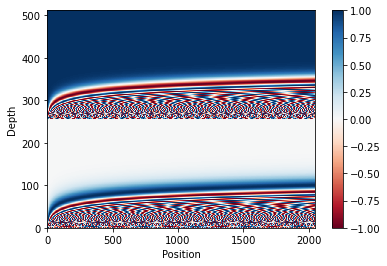

In [12]:
max_seq_len, d_model = 2048, 512
pe = positional_encoding(max_seq_len, d_model)[0]
pe = pe.reshape(max_seq_len, d_model//2, 2)
pe = pe.transpose(2,1,0)
pe = pe.reshape(d_model, max_seq_len)
plt.pcolormesh(pe, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

# Scaled Dot Product Attention

$\begin{equation*}\Large
Attention(Q,K,V) = softmax\left(\frac{QK^{T}}{\sqrt{d_k}}\right)V
\end{equation*}$

In [7]:
def scaled_dot_product_attention(q, k, v, attn_mask=None): # q,k[B, nheads, seq_len, depth]
    depth = q.size(-1)
    scale = depth**-0.5
    q = q*scale

    attn = torch.matmul(q, k.transpose(-2,-1)) # [B, nheads, seq_len_q, seq_len_k]
    if attn_mask is not None:
        attn += attn_mask
    attn = attn.softmax(dim=-1)
    # dropout
    out = torch.matmul(attn, v)    # [B, nheads, seq_len_q, depth_v]
    return out, attn

# Multi headed attention

In [8]:
class mha(nn.Module):  # multi headed attention
    def __init__(self, emb_dim=512, nheads=8):
        super().__init__()
        self.nheads = nheads
        self.qw = nn.Linear(emb_dim, emb_dim)
        self.kw = nn.Linear(emb_dim, emb_dim)
        self.vw = nn.Linear(emb_dim, emb_dim)
        self.out_proj = nn.Linear(emb_dim, emb_dim)

    def forward(self, query, key, value, attn_mask=None):   # [B, seq_len, emb_dim]
        batch_size, seq_len, emb_dim = query.shape
        q,k,v = self.qw(query), self.kw(key), self.vw(value) # [B, seq_len, emb_dim]
        
        q = q.view(batch_size, seq_len, self.nheads, -1)
        k = k.view_as(q)
        v = v.view_as(q)     # [B, seq_len, nheads, depth]   # emb_dim = nheads * depth
        
        q = q.transpose(-2,-3)
        k = k.transpose(-2,-3)
        v = v.transpose(-2,-3)  # [B, nheads, seq_len, depth]
        
        out, attn = scaled_dot_product_attention(q,k,v,attn_mask)   # [B, nheads, seq_len, depth]
        
        out = out.transpose(-2,-3)  # [B, seq_len, nheads, depth]
        
        out = out.reshape(batch_size, seq_len, -1)  # [B, seq_len, emb_dim]
        out = self.out_proj(out)     # [B, seq_len, emb_dim]
        return out, attn

# Transformer

![Transformer](img/transformer.png)

In [9]:
# just for feed forward network in Encoder and Decoder layers
def get_ffn(d_model, dp_rate=0.1, activation='relu'):
    if activation == 'relu':
        act_lyr = nn.ReLU()
    elif activation == 'gelu':
        act_lyr = nn.GELU()
    return nn.Sequential(OrderedDict([
            ('lin1', nn.Linear(d_model, d_model*4)),
            ('activation', act_lyr),
            ('dropout', nn.Dropout(dp_rate)),
            ('lin2', nn.Linear(d_model*4, d_model))
        ]))

In [10]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model=512, nheads=8, dp_rate=0.1, activation='relu'):
        super().__init__()
        self.attn = mha(emb_dim=d_model, nheads=nheads)
        self.dropout1 = nn.Dropout(dp_rate)
        self.ln1 = nn.LayerNorm(d_model)
        self.ffn = get_ffn(d_model, dp_rate, activation)
        self.dropout2 = nn.Dropout(dp_rate)
        self.ln2 = nn.LayerNorm(d_model)

    def forward(self, x, attn_mask=None):   # [B, seq_len, d_model]
        x = self.ln1(x + self.dropout1(self.attn(x,x,x, attn_mask)[0]))
        x = self.ln2(x + self.dropout2(self.ffn(x)))
        return x

In [8]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model=512, nheads=8, dp_rate=0.1, activation='relu'):
        super().__init__()
        self.attn1 = mha(emb_dim=d_model, nheads=nheads)
        self.dropout1 = nn.Dropout(dp_rate)
        self.ln1 = nn.LayerNorm(d_model)

        self.attn2 = mha(emb_dim=d_model, nheads=nheads)
        self.dropout2 = nn.Dropout(dp_rate)
        self.ln2 = nn.LayerNorm(d_model)

        self.ffn = get_ffn(d_model, dp_rate, activation)
        self.dropout3 = nn.Dropout(dp_rate)
        self.ln3 = nn.LayerNorm(d_model)
    
    def forward(self, x, enc_output, attn_mask=None, padding_mask=None):   # [B, seq_len, d_model]
        x = self.ln1(x + self.dropout1(self.attn1(x,x,x, attn_mask)[0]))
        x = self.ln1(x + self.dropout1(self.attn2(x,enc_output,enc_output, padding_mask)[0]))
        x = self.ln2(x + self.dropout2(self.ffn(x)))
        return x

In [9]:
class TransformerEncoder(nn.Module):
    def __init__(self, src_vocab_size, nlayers=6, d_model=512, nheads=8, dp_rate=0.1, activation='relu'):
        super().__init__()
        self.embedding = nn.Embedding(src_vocab_size, d_model)
        self.pos_enc = torch.tensor(positional_encoding(2048, d_model), requires_grad=False)
        self.enc_layers = nn.ModuleList([TransformerEncoderLayer(d_model, nheads, dp_rate, activation)
                                         for _ in range(nlayers)])   # repeat encoder layer N times
    
    def forward(self, x, attn_mask=None):
        x = self.embedding(x)
        x+= self.pos_enc
        for lyr in self.enc_layers:
            x = lyr(x, attn_mask)
        return x

In [10]:
class TransformerDecoder(nn.Module):
    def __init__(self, tgt_vocab_size, nlayers=6, d_model=512, nheads=8, dp_rate=0.1, activation='relu'):
        super().__init__()
        self.embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.pos_enc = torch.tensor(positional_encoding(2048, d_model), requires_grad=False)
        self.dec_layers = nn.ModuleList([TransformerDecoderLayer(d_model, nheads, dp_rate, activation)
                                         for _ in range(nlayers)])   # repeat decoder layer N times
    
    def forward(self, x, enc_output, attn_mask=None, padding_mask=None):
        x = self.embedding(x)
        x+= self.pos_enc
        for lyr in self.dec_layers:
            x = lyr(x, enc_output, attn_mask, padding_mask)
        return x

In [11]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512,
                 nheads=8, nlayers=6, dp_rate=0.1, activation='relu'):
        super().__init__()
        self.encoder = TransformerEncoder(src_vocab_size, nlayers, d_model, nheads, dp_rate, activation)
        self.decoder = TransformerDecoder(tgt_vocab_size, nlayers, d_model, nheads, dp_rate, activation)
        self.fout = nn.Linear(d_model, tgt_vocab_size)
        self.reset_parameters()

    def reset_parameters(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, src, tgt, attn_mask=None, padding_mask=None):
        x = self.encoder(src, attn_mask)
        x = self.decoder(tgt, x, attn_mask, padding_mask)
        x = self.fout(x)
        return x